# Deep Learning - Final Project
# Action Recognition
By Shu-Nong Wu | RIN: 661371234 | RCS: wus7
## 1. Introduction
&emsp;
This course, Deep Learning, covers topics such as machine learning fundamentals, deep neural networks, convolutional neural networks, recurrent neural networks, generative models, auto encoders, deep reinforcement learning, and probabilistic models. This final project combines knowledge gathered throughout the semester to classify sequences of human actions. The dataset UCF11 contains videos of people performing the following actions: basketball shooting, biking/cycling, diving, golf swinging, horseback riding, soccer juggling, swinging, tennis swinging, trampoline jumping, volleyball spiking, and walking with a dog. Each category contains approximately 100 videos split into several sequence. The goal is to classify each video sequence and determine what action is being performed in each video. 

&emsp;
Due to the fact that this dataset is comprised of images, a convolutional neural network **CNN** is required to extract features from images. These features are then passed to an **RNN** which captures the temporal information of theses video sequences. The overall architecture looks like an RNN stacked on top of an CNN. Based on the paper "Two Stream LSTM : A Deep Fusion Framework for Human Action Recognition" by Harshala Gammulle, Simon Denman, Sridha Sridharan, and Clinton Fookes, the authors were able to achieve state of the art performance on the UCF11 dataset by connecting several layer of VGG net to a fully connected layer and finally to an RNN comprised of **LSTM cells**.

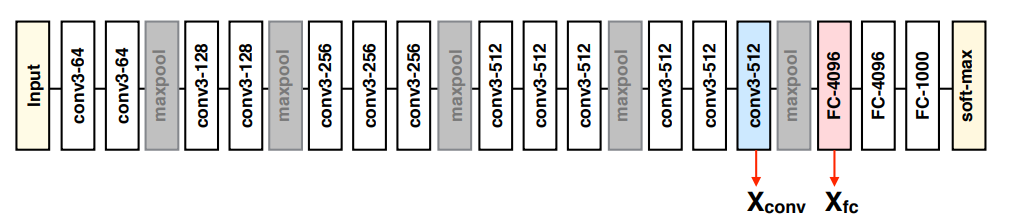

In [9]:
from IPython.display import Image
Image("report/sota_ucf11.PNG")

[Two Stream LSTM : A Deep Fusion Framework for Human Action Recognition: Implementation]

However, due to the fact that these videos are being resized to a smaller resolution, such a large convolutional network will lend itself to **over fitting** which is a big problem for this dataset. Instead a smaller network, shown below, will be used.

[Two Stream LSTM : A Deep Fusion Framework for Human Action Recognition: Implementation]: https://arxiv.org/pdf/1704.01194.pdf

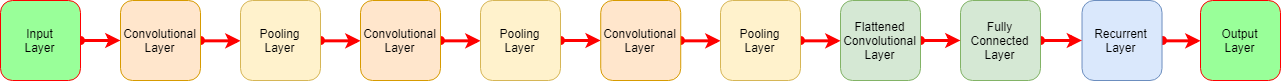

In [10]:
Image("report/my_model.png")

This report will cover the implementation and tuning of this neural network for the purposes of action recognition.



#### Import Dependencies

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import logging
from fp_utils import *
from datetime import datetime

#### Load and Preprocess Data
&emsp;
Initially, the videos are of size 320x240. There are several preprocessing steps that must be taken:

    1. Resize the video resolution from 320x240 to 64x64
    2. Divide each video into clips of length 30 frames using sliding window
    3. Normalize the pixel between 0 and 1 by dividing 255
    
The first two steps have already been implemented and the last step, normalization must be done locally.

&emsp;
Additionally, the sequence must be divided into training set and testing set. For this project, the train test split is not as straightforward. Because the dataset is organized by action category, a simple train test split on the raw data will cause all the later categories to go into the test set and the rest of the categories to go into the train set. Shuffling the dataset will also cause the sequences of one video to go into the both the train and test set. This will cause **data snooping** and one piece of data from the test set is contaminating the train set which will cause poor generalization when presented with the external test set that is being withheld. Therefore the test train split must be done within each category without shuffling to ensure that one video's sequences don’t fall into the train and test.

In [ ]:
with open('youtube_action_train_data_part1.pkl', 'rb') as data_file:
    sequences1, labels1 = pickle.load(data_file)
with open('youtube_action_train_data_part2.pkl', 'rb') as data_file:
    sequences2, labels2 = pickle.load(data_file)
    
sequences = np.concatenate((sequences1,sequences2), axis=0)
labels = np.concatenate((labels1,labels2), axis=0)
del sequences1, sequences2, labels1, labels2
sequences = sequences.astype(np.float32)
sequences = sequences/255.

train_seqs,train_labels,test_seqs,test_labels = train_test_split(sequences,labels)

train_data = Data(train_seqs, train_labels)
test_data = Data(test_seqs, test_labels)

NUM_TRAINING_SAMPLES = train_seqs.shape[0]
NUM_TESTING_SAMPLE = test_seqs.shape[0]
SEQ_LEN = 30
NUM_OUTPUTS = 11 
width, height, channels = 64, 64, 3

## 2. Model Architecture
&emsp;
As explained earlier, the architecture used for this assignment is a CNN stacked on top of an RNN. The CNN captures features from the images and the RNN captures the dependencies across time within a sequence of images. It was determined experimentally that the architecture used in programming assignment 4 was able to best classify the sequences. This architecture include 3 **convolutional layers** with a **max pooling layer** at the end. The final max pooling layer is flattened and connected to a **fully connected layer** which is fed into an RNN with LSTM cells. Finally the final state of the LSTM is fully connected to the **output layer**.
### 2.1. Hyper Parameters
&emsp;
When training this model, the model was able to over fit incredibly easily. Over fitting for this dataset is likely the result of a too little training data and the fact that the fully connected layers off the CNN and LSTM cells contain a lot of weights and biases thus increasing the complexity of the model. In other words these layers are able to embed a lot of information, it can be said that they have a large **capacity**. Therefore in order to obtain a model that can generalize well, measures must be taken to prevent over fitting. Two steps that are taken to mitigate over fitting are 1) **regularization** and 2) **dropout**. Both techniques reduce the model complexity. The theory behinds these two techniques will not be discussed in this report.

In [3]:
LEARNING_RATE = .001
LAMBDA = .001 # Regularization parameter
NUM_STEPS = 10000 
BATCH_SIZE = 16

### 2.2. Model Parameters
&emsp;
The low level implementation of the network is presented below. It should be noted that the way the code is structures is there is a list of dictionary’s. Each dictionary contains the parameters of a layer such as convolutional, full connected, etc. This list of model parameters are passes to a function called model_factory() which takes the list and constructs the layers of the model and returns the tensors as a list. This allows for fast prototyping and tuning of model parameters and structure. Implementation can be seen in fp_utils.py.

In [ ]:
model_params = [dict(layer_type='conv',
                     filters=8,
                     kernel_size=(1,6,6),
                     padding='VALID',
                     name='conv_l1'),
                dict(layer_type='pool',
                     name='pool_l1'),

                dict(layer_type='conv',
                     filters=16,
                     kernel_size=(1,6,6),
                     padding='VALID',
                     name='conv_l2'),     
                dict(layer_type='pool',
                     name='pool_l2'),

                dict(layer_type='conv',
                     filters=32,
                     kernel_size=(1,3,3),
                     padding='VALID',
                     name='conv_l3'),                
                dict(layer_type='pool',
                     name='pool_l3'),
                
                dict(layer_type='flat',
                     name='pool_l3_flat'),
                dict(layer_type='fc',
                     units=256,
                     drop_rate=.5,
                     bn_momentum=.99,
                     name='fc_l1'),
                
                dict(layer_type='lstm',
                     units=64,
                     drop_rate=.5,
                     name='lstm'),
                
                dict(layer_type='logits',
                     num_outputs=NUM_OUTPUTS,
                     name='logits')]

tf.reset_default_graph()

with tf.name_scope('input_data') as scope:
    X = tf.placeholder(shape=(None, SEQ_LEN, width, height, channels), dtype=tf.float32, name='img_seq')
    Y = tf.placeholder(shape=(None), dtype=tf.int64, name='label')
    training = tf.placeholder_with_default(input=False, shape=(), name='training')
layers = model_factory(model_params, X, training)
logits = layers[-1]
predict_op = tf.argmax(logits, 1, name='pred_op')

In [ ]:
print('Model Structure')
for layer in layers:
    print(layer)

### 2.4. Define Loss Function
Cross entropy loss is used as this is a classification problem. Regularization loss is added to reduce over fitting.

In [ ]:
with tf.name_scope('loss') as scope:
    regularizer = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y)
    loss = tf.reduce_mean(loss)+LAMBDA*tf.reduce_sum(regularizer)

### 2.5. Optimizer
An adaptive optimizer (Adams) is used as it converges the fastest.

In [189]:
with tf.name_scope('train') as scope:
    optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
    train_op = optimizer.minimize(loss)

## 3. Model Justification
### 3.1 Convolutional Neural Network Parameters
&emsp;
Three convolutional layers are used to capture the features of the images. For this model there were quite a few convolutional filters. This was done because there is a lot of image features to capture. Many of the images are quite complex. Due to the fact that convolutional layers contain fewer parameters it is not as big of a source of over fitting as the fully connected layers. Each convolutional layer is max pooled to make the model more invariant to translations. This is especially important for this dataset because there is a lot of translations in the images where people performing the actions are in various locations in the frame. Max pooling is also important for reducing the dimensionality of the final convolutional layer. This is important because once the final convolutional layer is flattened it will be connected to a fully connected layer. If the flattened layer is too large and connected to the fully connected layer then there will too many weights and biases. Because there needs a connection from every node of the flatten layer to every other node of the fully connected layer, the number of weights and biases increase exponentially. This will cause the model to over fit. Finally, another purpose the fully connected layer serves similar to that of layers in a deep neural network. Fully connected layers take combinations of lower level features and build higher level features out of them. The outputs of the fully connected layers are given to the RNN.

### 3.2. Recurrent Neural Network Parameters
&emsp;
As mentioned in previous sections, RNNs act as a state machine by taking the output of the hidden RNN layers, combining with the input, and feeding it back into the model. It is therefore able to capture information across time steps. The input data for this model are sequences of images. It is for this reason why an RNN was selected for this model. RNNs have weights for both the hidden layer, inputs, and outputs. In addition, LSTMs contain embed the states for the gates. In essence, RNNs have huge capacities and too many nodes will lead to over fitting. Therefore approximately 100 RNN units were used. Finally the output of the RNN must be connected to the output layer.

&emps;
At one point, multiple RNN layers were stacked to create a deep RNN. After some experimentation, no good results were gathered but more tinkering is needed. In addition, bidirectional RNNs are another configuration that can work for this data. Bidirectional RNNs captures dependencies forward and backward in time which can be useful in certain situations. For example if a movement at one frame can give better context to a frame at a previous time then a bidirectional RNN can be useful.

### 3.3. Other Improvements
&emsp;
Other improvements include Xavier initialization for initializing weights. L2 regularization for reducing over fitting. Dropout for reducing over fitting. ReLu activation function because it performs better than sigmoid.

## 4. Model Performance
Tuning this model was difficult as the model took a long time to overcome 50 percent.
#### Useful TF Ops

In [ ]:
# How often should we record/print
TB_PERIOD = 10
TRAIN_PERIOD = 1
TEST_PERIOD = 100
SAVE_PERIOD = 100

# For getting accuracy
num_correct = tf.equal(Y, predict_op)
accuracy_op = tf.reduce_mean(tf.cast(num_correct, dtype=tf.float32))
test_acc_ops = {'X':X,'Y':Y,'loss':loss,'accuracy_op':accuracy_op}
confusion_matrix = tf.confusion_matrix(Y, predict_op, num_classes=NUM_OUTPUTS)

# For saving a model
tf.get_collection('validation_nodes')
tf.add_to_collection('validation_nodes', X)
tf.add_to_collection('validation_nodes', Y)
tf.add_to_collection('validation_nodes', predict_op)
saver = tf.train.Saver(max_to_keep=1000)

# Tensorboard
time_now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
tensorboard_logdir = 'tf_log/run-1'
print('tensorboard log_dir: {}'.format(tensorboard_logdir))
writer = tf.summary.FileWriter(tensorboard_logdir)
writer.add_graph(tf.get_default_graph())

### 4.1. Train Model

In [ ]:
# Record training and testing loss and accuracy
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(1,NUM_STEPS+1):
        # Record testing loss/accuracy
        if step%TEST_PERIOD == 0 or step == 1:
            test_loss, test_acc = get_testing_loss_and_error(sess,test_data,test_acc_ops,test_batch_size=100)
            test_loss_hist.append(test_loss)
            test_acc_hist.append(test_acc)
            print('\rTest Step: {:<10} | Loss: {:<25} | Accuracy {:<20}'\
                  .format(step, test_loss, test_acc))
            
        # Save model
        if step%SAVE_PERIOD == 0 and test_acc_hist[-1] > .5:
            print('saving model with avg accuracy: {:.3f}'.format(test_acc_hist[-1]))
            xentropy = sum(train_acc_hist[-100:])/100.-test_acc_hist[-1]
            saver_filename = 'models/a{:.3f}_ex{}_e{}'.format(test_acc_hist[-1], 
                                                              xentropy,
                                                              step)
            saver.save(sess, saver_filename)
        
        # Load training data
        X_batch_train, Y_batch_train = train_data.random_batch(BATCH_SIZE)
        # Train and record training loss/accuracy
        train_loss, train_acc, _ = sess.run([loss, accuracy_op, train_op], 
                                            feed_dict={X:X_batch_train, 
                                                       Y:Y_batch_train, 
                                                       training:True})
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        print('{:.3f}+++{}'.format(sum(train_loss_hist[-10:])/10., sum(train_acc_hist[-10:])/10.),end='\r')
        
    # Get confusion matrix
    test_data.reset(shuffle=False)
    test_batch_size = 100
    num_test_batches = int(NUM_TESTING_SAMPLE/test_batch_size)+1
    confusion_matrix = []
    for _ in range(num_test_batches):
        X_batch_test, Y_batch_test = test_data.next_batch(test_batch_size)
        matrix = sess.run(confusion_matrix_op, feed_dict={X:X_batch_test, Y:Y_batch_test})
        confusion_matrix.append(matrix)
    confusion_matrix = sum(confusion_matrix)
        
time_elapse = time.time()-start_time
print('{:.3f} sec, {} iterations, {:.3f} iterations/sec'.format(time_elapse, NUM_STEPS, NUM_STEPS/time_elapse))

### 4.2. Plots Loss Over Steps

In [ ]:
plt.figure()
plt.plot(np.linspace(TRAIN_PERIOD, NUM_STEPS, int(NUM_STEPS/TRAIN_PERIOD)),
         train_loss_hist, 'b-', linewidth = 1.0)
plt.plot(np.linspace(0, NUM_STEPS, int((NUM_STEPS+TEST_PERIOD)/TEST_PERIOD)),
         test_loss_hist,'r-', linewidth = 1.0)
plt.title('Training and Testing Loss Over {} Iterations'.format(NUM_STEPS))
plt.legend(['Training Set', 'Testing Set'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### 4.3. Plots Accuracy Over Steps

In [ ]:
plt.figure()
plt.plot(np.linspace(TRAIN_PERIOD, NUM_STEPS, int(NUM_STEPS/TRAIN_PERIOD)),
         train_acc_hist, 'b-', linewidth = 1.0)
plt.plot(np.linspace(0, NUM_EPOCHS, int((NUM_EPOCHS+TEST_PERIOD)/TEST_PERIOD)),
         test_acc_hist,'r-', linewidth = 1.0)
plt.title('Training and Testing Accuracy Over {} Iterations'.format(NUM_STEPS))
plt.legend(['Training Set', 'Testing Set'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### 4.4. Confusion Matrix
Compares actual class vs predicted class in an organized table format.

In [ ]:
categories = ['basketball shooting', 
              'biking/cycling', 
              'diving', 
              'golf swinging', 
              'horseback riding', 
              'soccer juggling', 
              'swinging', 
              'tennis swinging', 
              'trampoline jumping', 
              'volleyball spiking', 
              'walking with a dog']
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(confusion_matrix)

ax.set_xticks(np.arange(len(categories)))
ax.set_yticks(np.arange(len(categories)))
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(categories)):
    for j in range(len(categories)):
        text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="w")

ax.set_title("Confusion Matrix",fontsize=20)
fig.tight_layout()
plt.show()

### 4.5. Per Class Accuracy

In [ ]:
num_actions = np.bincount(test_data.full_batch()[1])
for action, num_action, i in zip(categories, num_actions, range(NUM_OUTPUTS)):
    print('{} accuracy: {:.1f}%'.format(action, 100.*confusion_matrix[i,i]/num_action))